# Performing Table Joins

## Overview

This tutorial shows how to use GeoPandas to do a table join. In addition, we will be covering advanced data cleaning techniques to be able to merge datasets from different sources.

We will be working with 2 data layers for the Sri Lanka. Given the shapefile of Admin4 regions and a CSV file containing division-wise population statistics - we will learn how to merge them to display these indicators on a map.

Input Layers:
* `lka_admbnda_adm4_slsd_20220816.shp`: A shapefile of all Grama Niladhari (GN)Divisions (Admin Level 4) of Sri Lanka.
* `GN_Division_Age_Group_of_Population.csv`: Age-wise population for all GN Divisions of Sri Lanka.

Output:
* `srilanka.gpkg`: A geopackage containing merged dataset.

Data Credit: 
* Sri Lanka Population Statistics: Department of Census and Statistics - Sri Lanka.  Downloaded from DCS Map Portal](http://map.statistics.gov.lk/).
* Sri Lanka - Subnational Administrative Boundaries: Sri Lanka administrative levels 0-4 shapefiles and gazetteer. Downloaded from [HDX portal](https://data.humdata.org/dataset/cod-ab-lka).

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
try:
    import geopandas
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        !apt install libspatialindex-dev -qq
        !pip install fiona shapely pyproj rtree --quiet
        !pip install geopandas --quiet
    else:
        print('geopandas not found, please install via conda in your environment')

In [2]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [4]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

data_url = 'https://storage.googleapis.com/spatialthoughts-public-data/srilanka/'

shapefile = 'lka_admbnda_adm4_slsd_20220816'
exts = ['.shp', '.shx', '.dbf', '.prj']
csv_file = 'GN_Division_Age_Group_of_Population.csv'

for ext in exts:
  download(data_url + shapefile + ext)

download(data_url + csv_file)

Downloaded data/lka_admbnda_adm4_slsd_20220816.shp
Downloaded data/lka_admbnda_adm4_slsd_20220816.shx
Downloaded data/lka_admbnda_adm4_slsd_20220816.dbf
Downloaded data/lka_admbnda_adm4_slsd_20220816.prj
Downloaded data/GN_Division_Age_Group_of_Population.csv


## Procedure

### Pre-Process Data Table

The data table containing population couts is organized by 1 row per GN Division. We do not have a unique identifier that uniquely matches a GN Division. Since GN Division names are not unique amounf different provinces, we must create a unique identifier to be able to match it against another data source.

In [5]:
csv_path = os.path.join(data_folder, csv_file)
df = pd.read_csv(csv_path)
df

,GN Division,DS Division,District,Province,Total Population,Less than 10,10 ~ 19,20 ~ 29,30 ~ 39,40 ~ 49,50 ~ 59,60 ~ 69,70 ~ 79,80 ~ 89,90 and above
0,Sammanthranapura,Colombo,Colombo,Western,7829,1604,1373,1262,1251,944,796,400,131,52,16
1,Mattakkuliya,Colombo,Colombo,Western,28003,4932,4738,4379,4220,3702,2920,1944,834,239,95
2,Modara,Colombo,Colombo,Western,17757,3045,2791,3101,2688,2321,1872,1271,481,159,28
3,Madampitiya,Colombo,Colombo,Western,12970,2834,2415,2066,1940,1687,1147,581,238,52,10
4,Mahawatta,Colombo,Colombo,Western,8809,1529,1495,1406,1357,1198,953,555,213,75,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13984,Demeda,Deraniyagala,Kegalle,Sabaragamuwa,971,181,156,138,150,117,93,90,35,10,1
13985,Kosgahakanda,Deraniyagala,Kegalle,Sabaragamuwa,2336,360,364,343,331,295,293,216,107,26,1
13986,Yatiwala,Deraniyagala,Kegalle,Sabaragamuwa,1882,324,268,342,249,248,210,154,67,17,3
13987,Magala,Deraniyagala,Kegalle,Sabaragamuwa,1076,158,131,147,182,131,135,108,67,17,0


GN Division names are not unique, so they can't be used as identifiers for a join.

In [22]:
df[df['GN Division'].duplicated(keep=False)].sort_values('GN Division')

,GN Division,DS Division,District,Province,Total Population,Less than 10,10 ~ 19,20 ~ 29,30 ~ 39,40 ~ 49,50 ~ 59,60 ~ 69,70 ~ 79,80 ~ 89,90 and above
8944,Abakolawewa North,Ambanpola,Kurunegala,North Western,561,100,81,81,83,83,72,37,17,7,0
6521,Abakolawewa North,Weeraketiya,Hambantota,Southern,648,131,114,93,84,85,65,37,25,11,3
8954,Abakolawewa South,Ambanpola,Kurunegala,North Western,488,72,77,67,62,70,72,43,16,8,1
6520,Abakolawewa South,Weeraketiya,Hambantota,Southern,322,62,47,39,40,46,41,29,11,6,1
6303,Abhayapura,Lunugamvehera,Hambantota,Southern,624,123,87,98,120,46,71,59,11,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,Yatiyana East,Agalawatta,Kalutara,Western,1493,214,226,211,222,207,156,128,79,39,11
978,Yatiyana East,Minuwangoda,Gampaha,Western,2004,324,335,269,317,299,231,152,45,25,7
13634,Yodhagama,Aranayaka,Kegalle,Sabaragamuwa,760,129,124,88,99,108,99,67,35,9,2
13493,Yodhagama,Rambukkana,Kegalle,Sabaragamuwa,1421,259,223,182,204,206,168,122,41,13,3


Let's create a unique idenfier by merging the Admin4, Admin3, Admin2 and Admin1 names. We also remove trailing whiltespaces and convert the names to lowercase to ensure the match is case insensitive.

In [6]:
df_processed = df.copy()
df_processed['GN Division'] = df_processed['GN Division'].str.lower().str.strip()
df_processed['DS Division'] = df_processed['DS Division'].str.lower().str.strip()
df_processed['District'] = df_processed['District'].str.lower().str.strip()
df_processed['Province'] = df_processed['Province'].str.lower().str.strip()

df_processed['joinkey'] = df_processed['GN Division'] + df_processed['DS Division'] + df_processed['District'] + df_processed['Province']
df_processed

,GN Division,DS Division,District,Province,Total Population,Less than 10,10 ~ 19,20 ~ 29,30 ~ 39,40 ~ 49,50 ~ 59,60 ~ 69,70 ~ 79,80 ~ 89,90 and above,joinkey
0,sammanthranapura,colombo,colombo,western,7829,1604,1373,1262,1251,944,796,400,131,52,16,sammanthranapuracolombocolombowestern
1,mattakkuliya,colombo,colombo,western,28003,4932,4738,4379,4220,3702,2920,1944,834,239,95,mattakkuliyacolombocolombowestern
2,modara,colombo,colombo,western,17757,3045,2791,3101,2688,2321,1872,1271,481,159,28,modaracolombocolombowestern
3,madampitiya,colombo,colombo,western,12970,2834,2415,2066,1940,1687,1147,581,238,52,10,madampitiyacolombocolombowestern
4,mahawatta,colombo,colombo,western,8809,1529,1495,1406,1357,1198,953,555,213,75,28,mahawattacolombocolombowestern
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13984,demeda,deraniyagala,kegalle,sabaragamuwa,971,181,156,138,150,117,93,90,35,10,1,demedaderaniyagalakegallesabaragamuwa
13985,kosgahakanda,deraniyagala,kegalle,sabaragamuwa,2336,360,364,343,331,295,293,216,107,26,1,kosgahakandaderaniyagalakegallesabaragamuwa
13986,yatiwala,deraniyagala,kegalle,sabaragamuwa,1882,324,268,342,249,248,210,154,67,17,3,yatiwaladeraniyagalakegallesabaragamuwa
13987,magala,deraniyagala,kegalle,sabaragamuwa,1076,158,131,147,182,131,135,108,67,17,0,magaladeraniyagalakegallesabaragamuwa


We still have some duplicates. 

In [7]:
duplicate_df = df_processed[df_processed.duplicated('joinkey', keep=False)].sort_values('joinkey')
duplicate_df

,GN Division,DS Division,District,Province,Total Population,Less than 10,10 ~ 19,20 ~ 29,30 ~ 39,40 ~ 49,50 ~ 59,60 ~ 69,70 ~ 79,80 ~ 89,90 and above,joinkey
10341,ahugoda west,polgahawela,kurunegala,north western,533,82,82,55,78,90,64,48,23,8,3,ahugoda westpolgahawelakurunegalanorth western
10335,ahugoda west,polgahawela,kurunegala,north western,876,153,134,115,140,111,97,79,33,14,0,ahugoda westpolgahawelakurunegalanorth western
10694,aluthwatta,chilaw,puttalam,north western,1350,179,238,188,186,187,162,139,54,17,0,aluthwattachilawputtalamnorth western
10693,aluthwatta,chilaw,puttalam,north western,1582,247,250,222,274,188,187,145,57,12,0,aluthwattachilawputtalamnorth western
2781,dewahandiya east,udadumbara,kandy,central,224,38,34,33,29,40,28,12,7,3,0,dewahandiya eastudadumbarakandycentral
2793,dewahandiya east,udadumbara,kandy,central,378,58,65,50,48,49,57,32,12,6,1,dewahandiya eastudadumbarakandycentral
2481,gorakadoowa,walallavita,kalutara,western,938,147,139,128,131,121,99,95,59,14,5,gorakadoowawalallavitakalutarawestern
2487,gorakadoowa,walallavita,kalutara,western,1624,288,279,244,252,195,186,107,43,23,7,gorakadoowawalallavitakalutarawestern
699,halpe,divulapitiya,gampaha,western,2219,356,361,336,356,317,227,169,66,25,6,halpedivulapitiyagampahawestern
757,halpe,divulapitiya,gampaha,western,2559,450,373,335,455,330,302,179,98,30,7,halpedivulapitiyagampahawestern


Since these refer to the same region, we merge the data for duplicate admin4 regions. While merging the rows, we sum the population counts from each row having the same key.

In [8]:
df_processed.columns

Index(['GN Division', 'DS Division', 'District', 'Province',
       'Total Population', 'Less than 10', '10 ~ 19', '20 ~ 29', '30 ~ 39',
       '40 ~ 49', '50 ~ 59', '60 ~ 69', '70 ~ 79', '80 ~ 89', '90 and above',
       'joinkey'],
      dtype='object')

In [ ]:
df_dissolved = df_processed.groupby(['joinkey'],as_index=False).agg({
    'GN Division': 'first',
    'DS Division': 'first',
    'District': 'first',
    'Province': 'first',
    'Total Population': sum,
    'Less than 10': sum,
    '10 ~ 19': sum,
    '20 ~ 29': sum,
    '30 ~ 39': sum,
    '40 ~ 49': sum,
    '50 ~ 59': sum,
    '60 ~ 69': sum,
    '70 ~ 79': sum,
    '80 ~ 89': sum,
    '90 and above': sum
})
df_dissolved = df_dissolved[['joinkey', 'Total Population', 'Less than 10',
                             '10 ~ 19', '20 ~ 29', '30 ~ 39','40 ~ 49',
                             '50 ~ 59', '60 ~ 69', '70 ~ 79', '80 ~ 89',
                             '90 and above']]

In [24]:
print('Total Records of original table', len(df))
print('Total Records of processed table', len(df_dissolved))

Total Records of original table 13989
Total Records of processed table 13973


### Pre-Process Shapefile

Our shapefile comes from a different source and thus has a different structure. We need to match each feature with a record from the data table. We process the data to create a similar 'joinkey' and remove duplicates.

In [10]:
shapefile_path = os.path.join(data_folder, shapefile + '.shp')
gdf = gpd.read_file(shapefile_path)
gdf

,Shape_Leng,Shape_Area,ADM4_EN,ADM4_SI,ADM4_TA,ADM4_PCODE,ADM4_REF,ADM3_EN,ADM3_SI,ADM3_TA,...,ADM1_TA,ADM1_PCODE,ADM0_EN,ADM0_SI,ADM0_TA,ADM0_PCODE,date,validOn,validTo,geometry
0,0.019689,0.000015,Sammanthranapura,à·à¶¸à·à¶¸à¶±à·à¶­à·âà¶»à¶«à¶´à·à¶»,None,LK1103005,None,Colombo,à¶à·à· à¶¹,à®à¯à®´à¯à®®à¯à®ªà¯,...,à®®à¯à®²à¯ à®®à®¾à®à®¾à®£à®®à¯Â,LK1,Sri Lanka,à·à·âà¶»à· à¶½à¶à¶à·,à®à®²à®à¯à®à¯,LK,2022-08-02,2022-08-16,None,"POLYGON ((79.88040 6.98093, 79.88032 6.98062, ..."
1,0.072878,0.000177,Mattakkuliya,à¶¸à¶§à·à¶§à¶à·à¶à·à¶½à·à¶º,None,LK1103010,None,Colombo,à¶à·à· à¶¹,à®à¯à®´à¯à®®à¯à®ªà¯,...,à®®à¯à®²à¯ à®®à®¾à®à®¾à®£à®®à¯Â,LK1,Sri Lanka,à·à·âà¶»à· à¶½à¶à¶à·,à®à®²à®à¯à®à¯,LK,2022-08-02,2022-08-16,None,"POLYGON ((79.88217 6.97996, 79.88218 6.97995, ..."
2,0.052290,0.000064,Modara,à¶¸à·à¶¯à¶»,None,LK1103015,None,Colombo,à¶à·à· à¶¹,à®à¯à®´à¯à®®à¯à®ªà¯,...,à®®à¯à®²à¯ à®®à®¾à®à®¾à®£à®®à¯Â,LK1,Sri Lanka,à·à·âà¶»à· à¶½à¶à¶à·,à®à®²à®à¯à®à¯,LK,2022-08-02,2022-08-16,None,"POLYGON ((79.87507 6.96483, 79.87504 6.96479, ..."
3,0.019201,0.000023,Madampitiya,à¶¸à·à¶¯à¶¸à·à¶´à·à¶§à·à¶º,None,LK1103020,None,Colombo,à¶à·à· à¶¹,à®à¯à®´à¯à®®à¯à®ªà¯,...,à®®à¯à®²à¯ à®®à®¾à®à®¾à®£à®®à¯Â,LK1,Sri Lanka,à·à·âà¶»à· à¶½à¶à¶à·,à®à®²à®à¯à®à¯,LK,2022-08-02,2022-08-16,None,"POLYGON ((79.87852 6.96328, 79.87849 6.96314, ..."
4,0.033889,0.000042,Mahawatta,à¶¸à·à·à¶­à·à¶­,None,LK1103025,None,Colombo,à¶à·à· à¶¹,à®à¯à®´à¯à®®à¯à®ªà¯,...,à®®à¯à®²à¯ à®®à®¾à®à®¾à®£à®®à¯Â,LK1,Sri Lanka,à·à·âà¶»à· à¶½à¶à¶à·,à®à®²à®à¯à®à¯,LK,2022-08-02,2022-08-16,None,"POLYGON ((79.87252 6.96160, 79.87261 6.96151, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14038,0.149196,0.000260,Demeda,à¶¯à·à¶¸à·à¶¯,None,LK9233110,None,Deraniyagala,à¶¯à·à¶»à¶«à·à¶ºà¶à¶½,à®¤à¯à®°à®©à®¿à®¯à®¾à®à®²à¯,...,à®à®ªà®°à®à®®à¯à®µ à®®à®¾à®à®¾à®£à®®à¯,LK9,Sri Lanka,à·à·âà¶»à· à¶½à¶à¶à·,à®à®²à®à¯à®à¯,LK,2022-08-02,2022-08-16,None,"POLYGON ((80.35891 6.87436, 80.35961 6.87238, ..."
14039,0.143733,0.000765,Kosgahakanda,à¶à·à·à·à¶à·à¶à¶±à·à¶¯,None,LK9233115,None,Deraniyagala,à¶¯à·à¶»à¶«à·à¶ºà¶à¶½,à®¤à¯à®°à®©à®¿à®¯à®¾à®à®²à¯,...,à®à®ªà®°à®à®®à¯à®µ à®®à®¾à®à®¾à®£à®®à¯,LK9,Sri Lanka,à·à·âà¶»à· à¶½à¶à¶à·,à®à®²à®à¯à®à¯,LK,2022-08-02,2022-08-16,None,"POLYGON ((80.37824 6.89164, 80.37861 6.89139, ..."
14040,0.122895,0.000583,Yatiwala,à¶ºà¶§à·à·à¶½,None,LK9233120,None,Deraniyagala,à¶¯à·à¶»à¶«à·à¶ºà¶à¶½,à®¤à¯à®°à®©à®¿à®¯à®¾à®à®²à¯,...,à®à®ªà®°à®à®®à¯à®µ à®®à®¾à®à®¾à®£à®®à¯,LK9,Sri Lanka,à·à·âà¶»à· à¶½à¶à¶à·,à®à®²à®à¯à®à¯,LK,2022-08-02,2022-08-16,None,"POLYGON ((80.40891 6.87830, 80.40845 6.87784, ..."
14041,0.246448,0.001756,Magala,à¶¸à·à¶à¶½,None,LK9233125,None,Deraniyagala,à¶¯à·à¶»à¶«à·à¶ºà¶à¶½,à®¤à¯à®°à®©à®¿à®¯à®¾à®à®²à¯,...,à®à®ªà®°à®à®®à¯à®µ à®®à®¾à®à®¾à®£à®®à¯,LK9,Sri Lanka,à·à·âà¶»à· à¶½à¶à¶à·,à®à®²à®à¯à®à¯,LK,2022-08-02,2022-08-16,None,"POLYGON ((80.41601 6.88094, 80.41600 6.88093, ..."


In [11]:
gdf_processed = gdf.copy()
gdf_processed = gdf_processed.rename(columns = {
    'ADM4_EN': 'GN Division',
    'ADM3_EN': 'DS Division',
    'ADM2_EN': 'District',
    'ADM1_EN': 'Province'})

gdf_processed['GN Division'] = gdf_processed['GN Division'].str.lower().str.strip()
gdf_processed['DS Division'] = gdf_processed['DS Division'].str.lower().str.strip()
gdf_processed['District'] = gdf_processed['District'].str.lower().str.strip()
gdf_processed['Province'] = gdf_processed['Province'].str.lower().str.strip()

gdf_processed['joinkey'] = gdf_processed['GN Division'] + gdf_processed['DS Division'] + gdf_processed['District'] + gdf_processed['Province']
gdf_processed = gdf_processed[['GN Division', 'DS Division', 'District', 'Province', 'joinkey', 'geometry']]
gdf_processed

,GN Division,DS Division,District,Province,joinkey,geometry
0,sammanthranapura,colombo,colombo,western,sammanthranapuracolombocolombowestern,"POLYGON ((79.88040 6.98093, 79.88032 6.98062, ..."
1,mattakkuliya,colombo,colombo,western,mattakkuliyacolombocolombowestern,"POLYGON ((79.88217 6.97996, 79.88218 6.97995, ..."
2,modara,colombo,colombo,western,modaracolombocolombowestern,"POLYGON ((79.87507 6.96483, 79.87504 6.96479, ..."
3,madampitiya,colombo,colombo,western,madampitiyacolombocolombowestern,"POLYGON ((79.87852 6.96328, 79.87849 6.96314, ..."
4,mahawatta,colombo,colombo,western,mahawattacolombocolombowestern,"POLYGON ((79.87252 6.96160, 79.87261 6.96151, ..."
...,...,...,...,...,...,...
14038,demeda,deraniyagala,kegalle,sabaragamuwa,demedaderaniyagalakegallesabaragamuwa,"POLYGON ((80.35891 6.87436, 80.35961 6.87238, ..."
14039,kosgahakanda,deraniyagala,kegalle,sabaragamuwa,kosgahakandaderaniyagalakegallesabaragamuwa,"POLYGON ((80.37824 6.89164, 80.37861 6.89139, ..."
14040,yatiwala,deraniyagala,kegalle,sabaragamuwa,yatiwaladeraniyagalakegallesabaragamuwa,"POLYGON ((80.40891 6.87830, 80.40845 6.87784, ..."
14041,magala,deraniyagala,kegalle,sabaragamuwa,magaladeraniyagalakegallesabaragamuwa,"POLYGON ((80.41601 6.88094, 80.41600 6.88093, ..."


There are some duplicate polygons having the same 'joinkey'.

In [12]:
duplicate_gdf = gdf_processed[gdf_processed.duplicated('joinkey', keep=False)].sort_values('joinkey')
duplicate_gdf

,GN Division,DS Division,District,Province,joinkey,geometry
7879,[unknown],eravur pattu,batticaloa,eastern,[unknown]eravur pattubatticaloaeastern,"POLYGON ((81.59942 7.77887, 81.59955 7.77876, ..."
7877,[unknown],eravur pattu,batticaloa,eastern,[unknown]eravur pattubatticaloaeastern,"POLYGON ((81.62471 7.78231, 81.62462 7.78238, ..."
7876,[unknown],eravur pattu,batticaloa,eastern,[unknown]eravur pattubatticaloaeastern,"POLYGON ((81.60296 7.78297, 81.60295 7.78290, ..."
7875,[unknown],eravur pattu,batticaloa,eastern,[unknown]eravur pattubatticaloaeastern,"POLYGON ((81.60157 7.78693, 81.60159 7.78693, ..."
7838,[unknown],eravur pattu,batticaloa,eastern,[unknown]eravur pattubatticaloaeastern,"POLYGON ((81.60935 7.79416, 81.60937 7.79408, ..."
...,...,...,...,...,...,...
2455,miriswatta,walallawita,kalutara,western,miriswattawalallawitakalutarawestern,"POLYGON ((80.09314 6.43583, 80.09315 6.43582, ..."
1389,sapugasthenna,attanagalla,gampaha,western,sapugasthennaattanagallagampahawestern,"POLYGON ((80.17102 7.10247, 80.17166 7.10118, ..."
1334,sapugasthenna,attanagalla,gampaha,western,sapugasthennaattanagallagampahawestern,"POLYGON ((80.04911 7.12307, 80.04923 7.12303, ..."
10612,udappuwa,mundel,puttalam,north western,udappuwamundelputtalamnorth western,"POLYGON ((79.79870 7.74958, 79.79863 7.74951, ..."


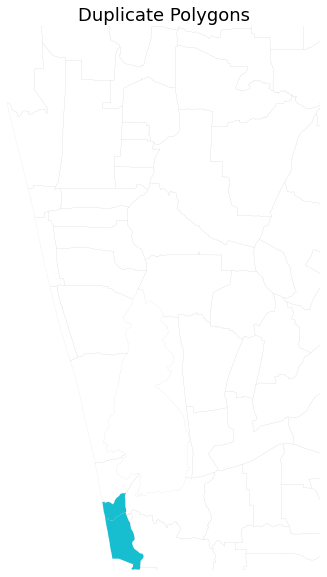

In [45]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)

# Plot all features and highlight duplicates
gdf_processed.plot(ax=ax, facecolor='none', edgecolor='#bdbdbd', linewidth=0.1)
duplicate_gdf.plot('joinkey', ax=ax, categorical=True, linewidth=0.5)

# Zoom to a specific region
selected = gdf_processed[gdf_processed['DS Division'] == 'mundel']
minx, miny, maxx, maxy = selected.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.set_axis_off()
ax.set_title('Duplicate Polygons', size = 18)

plt.show()

We dissolve (merge) these polygon boundaries to create a single region from multiple polygons having the same attributes.

In [13]:
gdf_dissolved = gdf_processed.dissolve(by='joinkey', aggfunc={
    'GN Division': 'first',
    'DS Division': 'first',
    'District': 'first',
    'Province': 'first'})
gdf_dissolved = gdf_dissolved.reset_index()

In [25]:
print('Total Records of original shapefile', len(gdf))
print('Total Records of processed shapefile', len(gdf_dissolved))

Total Records of original shapefile 14043
Total Records of processed shapefile 13987


### Table Join

Finally, we do a table join using GeoPandas merge().

We have almost one-to-one match between the shapefile and table now. There are still a few polygons that do not have corresponding population counts. They will be set to null values during the join.

In [48]:
print('Total Records of processed shapefile', len(gdf_dissolved))
print('Total Records of processed table', len(df_dissolved))

Total Records of processed shapefile 13987
Total Records of processed table 13973


In [49]:
merged = gdf_dissolved.merge(df_dissolved, on='joinkey')
merged

,joinkey,geometry,GN Division,DS Division,District,Province,Total Population,Less than 10,10 ~ 19,20 ~ 29,30 ~ 39,40 ~ 49,50 ~ 59,60 ~ 69,70 ~ 79,80 ~ 89,90 and above
0,07 gammanayaanamaduwaputtalamnorth western,"POLYGON ((80.02984 7.95988, 80.02984 7.95988, ...",07 gammanaya,anamaduwa,puttalam,north western,645,122,68,107,88,75,114,52,8,5,6
1,08 elaminipekandycentral,"POLYGON ((80.96322 7.38617, 80.96303 7.38657, ...",08 ela,minipe,kandy,central,671,128,110,111,105,81,70,37,21,7,1
2,80 yayawilgamuwamatalecentral,"POLYGON ((80.95325 7.50820, 80.95339 7.50768, ...",80 yaya,wilgamuwa,matale,central,951,193,128,141,166,111,110,65,27,8,2
3,abakolawewa northambanpolakurunegalanorth western,"POLYGON ((80.27272 7.92435, 80.27280 7.92406, ...",abakolawewa north,ambanpola,kurunegala,north western,561,100,81,81,83,83,72,37,17,7,0
4,abakolawewa northweeraketiyahambantotasouthern,"POLYGON ((80.80333 6.19424, 80.80335 6.19422, ...",abakolawewa north,weeraketiya,hambantota,southern,648,131,114,93,84,85,65,37,25,11,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10536,yogapuram westthunukkaimullaitivunorthern,"POLYGON ((80.29207 9.13879, 80.29213 9.13877, ...",yogapuram west,thunukkai,mullaitivu,northern,356,51,82,47,54,37,34,35,14,1,1
10537,yogiyanadankotuwaputtalamnorth western,"POLYGON ((79.92961 7.29382, 79.92964 7.29360, ...",yogiyana,dankotuwa,puttalam,north western,865,107,138,103,114,142,110,90,38,17,6
10538,yongammullamaharagampahawestern,"MULTIPOLYGON (((80.06072 7.07954, 80.06151 7.0...",yongammulla,mahara,gampaha,western,686,96,99,81,105,112,71,58,37,23,4
10539,yovungamaberuwalakalutarawestern,"POLYGON ((80.02848 6.51030, 80.02850 6.51027, ...",yovungama,beruwala,kalutara,western,1023,207,140,154,192,100,110,83,27,8,2


### Save the datasets

In [51]:
output_dir = 'output'
output_filename = 'srilanka.gpkg'
output_path = os.path.join(output_dir, output_filename)

gdf_dissolved.to_file(driver='GPKG', filename=output_path, layer='admin4polygons', encoding='utf-8')
merged.to_file(driver='GPKG', filename=output_path, layer='merged', encoding='utf-8')

print('Successfully written output file at {}'.format(output_path))


Successfully written output file at output/srilanka.gpkg
